<a href="https://colab.research.google.com/github/ihab09/CE888/blob/main/project/assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 1.9MB 5.6MB/s 
     |████████████████████████████████| 3.2MB 25.5MB/s 
     |████████████████████████████████| 890kB 36.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=5400c4056897c6ca5eebc6534ad6ebbb4433d74b5ff75600fd094546306315e2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import urllib.request
import csv

from transformers import AutoTokenizer, AutoModel, TFAutoModel
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

from scipy.special import softmax

import torch
from torch.utils.data import Dataset, DataLoader

pd.options.mode.chained_assignment = None  # default='warn'

# Exploratory Data Analysis

## Hate Speech Detection Dataset

Loading the Dataset

In [3]:
hate_train_df = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_text.txt", sep="\n", skip_blank_lines=False, header=None, quoting=csv.QUOTE_NONE,)
hate_train_df.columns= ["tweet"]
hate_train_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_labels.txt", sep="\n", header=None)
hate_train_labels.columns= ["label"]

hate_val_df = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/val_text.txt", sep="\n", skip_blank_lines=False, quoting=csv.QUOTE_NONE, header=None)
hate_val_df.columns= ["tweet"]
hate_val_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/val_labels.txt", sep="\n", header=None)
hate_val_labels.columns= ["label"]

hate_test_df = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/test_text.txt", sep="\n", quoting=csv.QUOTE_NONE, skip_blank_lines=False, header=None)
hate_test_df.columns= ["tweet"]
hate_test_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/test_labels.txt", sep="\n", header=None)
hate_test_labels.columns= ["label"]

hate_train_df

,tweet
0,@user nice new signage. Are you not concerned ...
1,A woman who you fucked multiple times saying y...
2,@user @user real talk do you have eyes or were...
3,your girlfriend lookin at me like a groupie in...
4,Hysterical woman like @user
...,...
8995,Oooohhhh bitch didn't even listen to the dead ...
8996,@user Good Luck @user More Americans #WalkAway...
8997,Bitch you can't keep up so stop trying
8998,@user @user @user @user @user @user Japan is a...


Checking whether the data is loaded correctly by checking the dimensions of the data frames for the training, validation, and testing datasets to match the dimensions of their corresponding labels dataframes.


In [4]:
print(hate_train_df.shape, hate_train_labels.shape)
print(hate_val_df.shape, hate_val_labels.shape)
print(hate_test_df.shape, hate_test_labels.shape)


(9000, 1) (9000, 1)
(1000, 1) (1000, 1)
(2970, 1) (2970, 1)


How the Data is Split

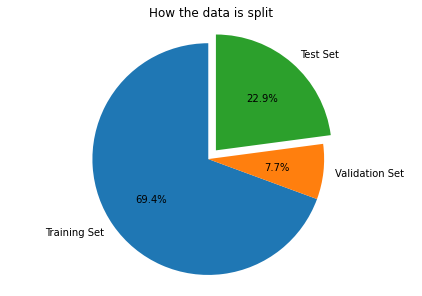

In [5]:
# Pie chart
labels = ['Training Set', 'Validation Set', 'Test Set']
sizes = [len(hate_train_labels), len(hate_val_labels), len(hate_test_labels)]
explode = (0, 0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.title("How the data is split")
plt.show()

In [6]:
# Checking the labels
hate_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/mapping.txt", sep="\t", header=None)
hate_labels

,0,1
0,0,not-hate
1,1,hate


Data Statistics:

In [7]:
print("Training Data Statistics: ")
print("Total number of tweets:", hate_train_labels.shape[0])
print("Number of Not Hateful tweets:", int(hate_train_labels.value_counts()[0]))
print("Number of Hateful tweets:", int(hate_train_labels.value_counts()[1]), "\n")

print("Validation Data Statistics: ")
print("Total number of tweets:", hate_val_labels.shape[0])
print("Number of Not Hateful tweets:", int(hate_val_labels.value_counts()[0]))
print("Number of Hateful tweets:", int(hate_val_labels.value_counts()[1]), "\n")

print("Testing Data Statistics: ")
print("Total number of tweets:", hate_test_labels.shape[0])
print("Number of Not Hateful tweets:", int(hate_test_labels.value_counts()[0]))
print("Number of Hateful tweets:", int(hate_test_labels.value_counts()[1]))

Training Data Statistics: 
Total number of tweets: 9000
Number of Not Hateful tweets: 5217
Number of Hateful tweets: 3783 

Validation Data Statistics: 
Total number of tweets: 1000
Number of Not Hateful tweets: 573
Number of Hateful tweets: 427 

Testing Data Statistics: 
Total number of tweets: 2970
Number of Not Hateful tweets: 1718
Number of Hateful tweets: 1252


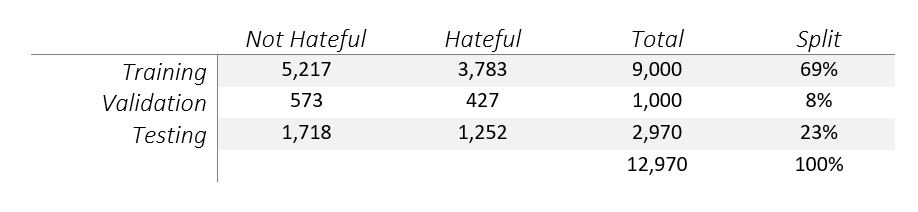

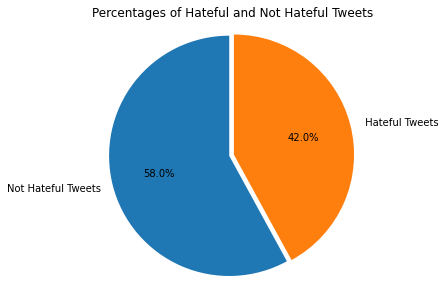

In [8]:
# Pie chart
not_hateful_count = hate_train_labels[hate_train_labels.label == 0].shape[0]
hateful_count = hate_train_labels[hate_train_labels.label == 1].shape[0]

labels = ['Not Hateful Tweets', ' Hateful Tweets']
sizes = [not_hateful_count, hateful_count]
fig1, ax1 = plt.subplots()
explode = (0.02, 0.02)  
ax1.pie(sizes, explode= explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.title("Percentages of Hateful and Not Hateful Tweets")
plt.show()


Distribution of Hateful and Not Hateful Tweets in All Datasets

[Text(0, 0, 'Not Hateful Tweets'), Text(0, 0, ' Hateful Tweets')]

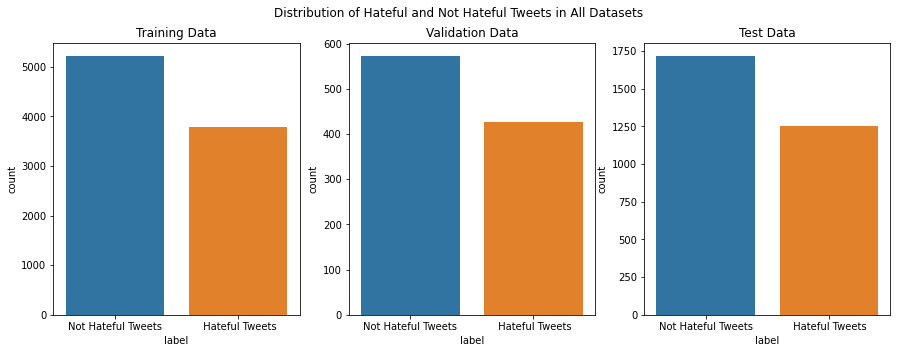

In [9]:
# Count Plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle('Distribution of Hateful and Not Hateful Tweets in All Datasets')

sns.countplot(ax=axes[0], x=hate_train_labels.label)
axes[0].set_title('Training Data')
axes[0].set_xticklabels(labels)

sns.countplot(ax=axes[1], x=hate_val_labels.label)
axes[1].set_title('Validation Data')
axes[1].set_xticklabels(labels)

sns.countplot(ax=axes[2], x=hate_test_labels.label)
axes[2].set_title('Test Data')
axes[2].set_xticklabels(labels)


## Emotion Recognition Dataset

Loading the datasets

In [10]:
emotion_train_df = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_text.txt", sep="\t", skip_blank_lines=False, quoting=csv.QUOTE_NONE, header=None)
emotion_train_df.columns= ["tweet"]
emotion_train_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_labels.txt", sep="\n", header=None)
emotion_train_labels.columns= ["label"]

emotion_val_df = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_text.txt", sep="\n", skip_blank_lines=False, quoting=csv.QUOTE_NONE, header=None)
emotion_val_df.columns= ["tweet"]
emotion_val_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_labels.txt", sep="\n", header=None)
emotion_val_labels.columns= ["label"]

emotion_test_df = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_text.txt", sep="\n", quoting=csv.QUOTE_NONE, skip_blank_lines=False, header=None)
emotion_test_df.columns= ["tweet"]
emotion_test_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_labels.txt", sep="\n", header=None)
emotion_test_labels.columns= ["label"]

emotion_train_df

,tweet
0,“Worry is a down payment on a problem you may ...
1,My roommate: it's okay that we can't spell bec...
2,No but that's so cute. Atsu was probably shy a...
3,Rooneys fucking untouchable isn't he? Been fuc...
4,it's pretty depressing when u hit pan on ur fa...
...,...
3252,I get discouraged because I try for 5 fucking ...
3253,The @user are in contention and hosting @user ...
3254,@user @user @user @user @user as a fellow UP g...
3255,You have a #problem? Yes! Can you do #somethin...


Checking whether the data is loaded correctly by checking the dimensions of the data frames for the training, validation, and testing datasets to match the dimensions of their corresponding labels dataframes.


```
# This is formatted as code
```



In [11]:
# Checking whether the data is loaded correctly by checking the dimensions of the data frames for the training, validation, and testing datasets matches the dimensions of their corresponding labels datasets.
print(emotion_train_df.shape, emotion_train_labels.shape)
print(emotion_val_df.shape, emotion_val_labels.shape)
print(emotion_test_df.shape, emotion_test_labels.shape)

(3257, 1) (3257, 1)
(374, 1) (374, 1)
(1421, 1) (1421, 1)


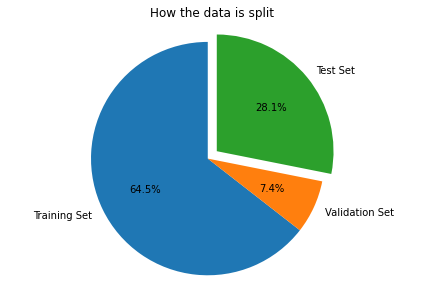

In [12]:
# Pie chart
labels = ['Training Set', 'Validation Set', 'Test Set']
sizes = [len(emotion_train_labels), len(emotion_val_labels), len(emotion_test_labels)]
explode = (0, 0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.title("How the data is split")
plt.show()


Data statitics:

In [13]:
# Checking the labels
emotion_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/mapping.txt", sep="\t", header=None)
emotion_labels

,0,1
0,0,anger
1,1,joy
2,2,optimism
3,3,sadness


In [14]:
print("Training Data Statistics: ")
print("Total number of tweets:", emotion_train_labels.shape[0])
print("Number of Anger tweets:", int(emotion_train_labels.value_counts()[0]))
print("Number of Joy tweets:", int(emotion_train_labels.value_counts()[1]))
print("Number of Optimism tweets:", int(emotion_train_labels.value_counts()[2]))
print("Number of Sadness tweets:", int(emotion_train_labels.value_counts()[3]), "\n")

print("Validation Data Statistics: ")
print("Total number of tweets:", emotion_val_labels.shape[0])
print("Number of Anger tweets:", int(emotion_val_labels.value_counts()[0]))
print("Number of Joy tweets:", int(emotion_val_labels.value_counts()[1]))
print("Number of Optimism tweets:", int(emotion_val_labels.value_counts()[2]))
print("Number of Sadness tweets:", int(emotion_val_labels.value_counts()[3]), "\n")

print("Testing Data Statistics: ")
print("Total number of tweets:", emotion_test_labels.shape[0])
print("Number of Anger tweets:", int(emotion_test_labels.value_counts()[0]))
print("Number of Joy tweets:", int(emotion_test_labels.value_counts()[1]))
print("Number of Optimism tweets:", int(emotion_test_labels.value_counts()[2]))
print("Number of Sadness tweets:", int(emotion_test_labels.value_counts()[3]))

Training Data Statistics: 
Total number of tweets: 3257
Number of Anger tweets: 1400
Number of Joy tweets: 708
Number of Optimism tweets: 294
Number of Sadness tweets: 855 

Validation Data Statistics: 
Total number of tweets: 374
Number of Anger tweets: 160
Number of Joy tweets: 97
Number of Optimism tweets: 28
Number of Sadness tweets: 89 

Testing Data Statistics: 
Total number of tweets: 1421
Number of Anger tweets: 558
Number of Joy tweets: 358
Number of Optimism tweets: 123
Number of Sadness tweets: 382


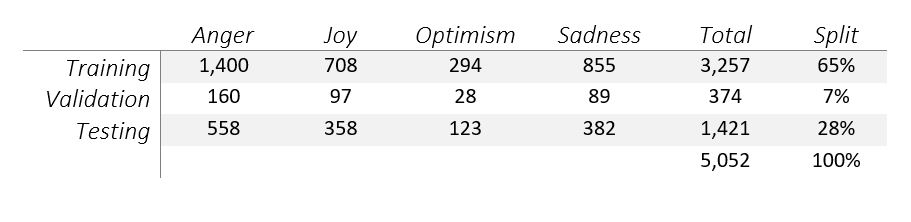

In [15]:
data = emotion_train_labels.groupby("label").sum()
data

""
label
0
1
2
3


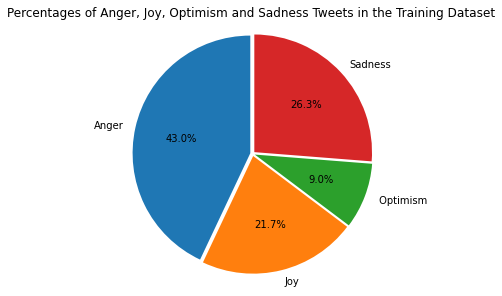

In [16]:
# Pie chart
emo_ang_count = emotion_train_labels[emotion_train_labels.label == 0].shape[0]
emo_joy_count = emotion_train_labels[emotion_train_labels.label == 1].shape[0]
emo_opt_count = emotion_train_labels[emotion_train_labels.label == 2].shape[0]
emo_sad_count = emotion_train_labels[emotion_train_labels.label == 3].shape[0]

labels = ['Anger', 'Joy', ' Optimism', 'Sadness']
sizes = [emo_ang_count, emo_joy_count, emo_opt_count, emo_sad_count]
fig1, ax1 = plt.subplots()
explode = (0.02, 0.02, 0.02, 0.02)  
ax1.pie(sizes, explode= explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.title("Percentages of Anger, Joy, Optimism and Sadness Tweets in the Training Dataset")
plt.show()


[Text(0, 0, 'Anger'),
 Text(0, 0, 'Joy'),
 Text(0, 0, ' Optimism'),
 Text(0, 0, 'Sadness')]

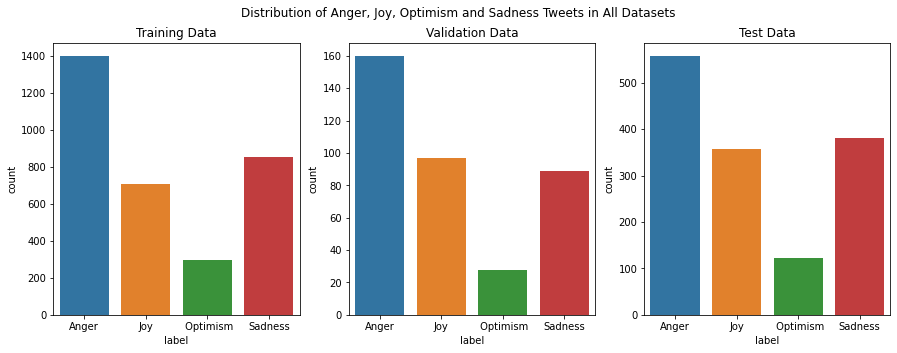

In [17]:
# Count Plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle('Distribution of Anger, Joy, Optimism and Sadness Tweets in All Datasets')

sns.countplot(ax=axes[0], x=emotion_train_labels.label)
axes[0].set_title('Training Data')
axes[0].set_xticklabels(labels)

sns.countplot(ax=axes[1], x=emotion_val_labels.label)
axes[1].set_title('Validation Data')
axes[1].set_xticklabels(labels)

sns.countplot(ax=axes[2], x=emotion_test_labels.label)
axes[2].set_title('Test Data')
axes[2].set_xticklabels(labels)

## Sentiment Analysis Dataset

Loading the datasets:

In [18]:
sentiment_train_df = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_text.txt", sep="\t", skip_blank_lines=False, quoting=csv.QUOTE_NONE, header=None)
sentiment_train_df.columns= ["tweet"]
sentiment_train_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_labels.txt", sep="\n", header=None)
sentiment_train_labels.columns= ["label"]

sentiment_val_df = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/val_text.txt", sep="\n", skip_blank_lines=False, quoting=csv.QUOTE_NONE, header=None)
sentiment_val_df.columns= ["tweet"]
sentiment_val_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/val_labels.txt", sep="\n", header=None)
sentiment_val_labels.columns= ["label"]

sentiment_test_df = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_text.txt", sep="\n", quoting=csv.QUOTE_NONE, skip_blank_lines=False, header=None)
sentiment_test_df.columns= ["tweet"]
sentiment_test_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_labels.txt", sep="\n", header=None)
sentiment_test_labels.columns= ["label"]

sentiment_train_df

,tweet
0,"""QT @user In the original draft of the 7th boo..."
1,"""Ben Smith / Smith (concussion) remains out of..."
2,Sorry bout the stream last night I crashed out...
3,Chase Headley's RBI double in the 8th inning o...
4,@user Alciato: Bee will invest 150 million in ...
...,...
45610,"@user \""""So amazing to have the beautiful Lady..."
45611,"9 September has arrived, which means Apple's n..."
45612,Leeds 1-1 Sheff Wed. Giuseppe Bellusci securin...
45613,@user no I'm in hilton head till the 8th lol g...


Checking whether the data is loaded correctly by checking the dimensions of the data frames for the training, validation, and testing datasets to match the dimensions of their corresponding labels dataframes.


In [19]:
print(sentiment_train_df.shape, sentiment_train_labels.shape)
print(sentiment_val_df.shape, sentiment_val_labels.shape)
print(sentiment_test_df.shape, sentiment_test_labels.shape)

(45615, 1) (45615, 1)
(2000, 1) (2000, 1)
(12284, 1) (12284, 1)


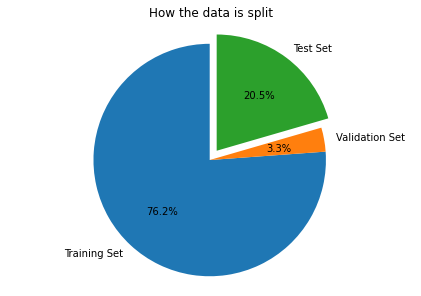

In [20]:
# Pie chart
labels = ['Training Set', 'Validation Set', 'Test Set']
sizes = [len(sentiment_train_labels), len(sentiment_val_labels), len(sentiment_test_labels)]
explode = (0, 0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.title("How the data is split")
plt.show()


In [21]:
# Loading the checking the labels
sentiment_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/mapping.txt", sep="\t", header=None)
sentiment_labels

,0,1
0,0,negative
1,1,neutral
2,2,positive


Data statistics:

In [22]:
print("Training Data Statistics: ")
print("Total number of tweets:", sentiment_train_labels.shape[0])
print("Number of Negative tweets:", int(sentiment_train_labels.value_counts()[0]))
print("Number of Neutral tweets:", int(sentiment_train_labels.value_counts()[1]))
print("Number of Positive tweets:", int(sentiment_train_labels.value_counts()[2]),"\n")

print("Validation Data Statistics: ")
print("Total number of tweets:", sentiment_val_labels.shape[0])
print("Number of Negative tweets:", int(sentiment_val_labels.value_counts()[0]))
print("Number of Neutral tweets:", int(sentiment_val_labels.value_counts()[1]))
print("Number of Positive tweets:", int(sentiment_val_labels.value_counts()[2]),"\n")

print("Testing Data Statistics: ")
print("Total number of tweets:", sentiment_test_labels.shape[0])
print("Number of Negative tweets:", int(sentiment_test_labels.value_counts()[0]))
print("Number of Neutral tweets:", int(sentiment_test_labels.value_counts()[1]))
print("Number of Positive tweets:", int(sentiment_test_labels.value_counts()[2]))

Training Data Statistics: 
Total number of tweets: 45615
Number of Negative tweets: 7093
Number of Neutral tweets: 20673
Number of Positive tweets: 17849 

Validation Data Statistics: 
Total number of tweets: 2000
Number of Negative tweets: 312
Number of Neutral tweets: 869
Number of Positive tweets: 819 

Testing Data Statistics: 
Total number of tweets: 12284
Number of Negative tweets: 3972
Number of Neutral tweets: 5937
Number of Positive tweets: 2375


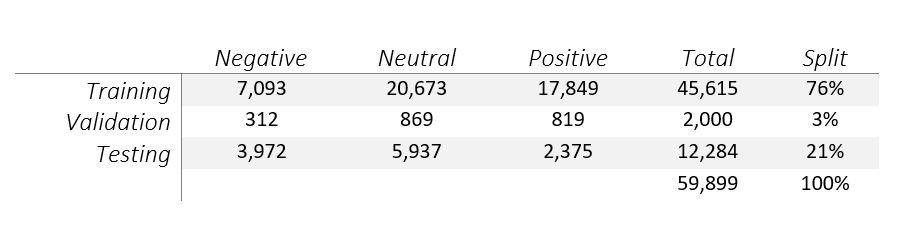

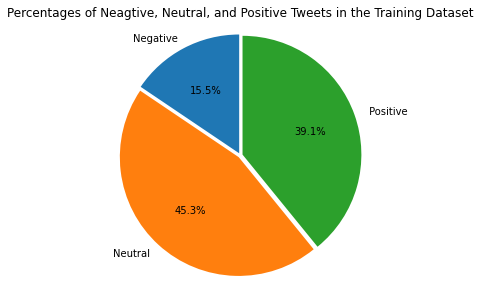

In [23]:
# Pie chart
senti_neg_count = sentiment_train_labels[sentiment_train_labels.label == 0].shape[0]
senti_neut_count = sentiment_train_labels[sentiment_train_labels.label == 1].shape[0]
senti_pos_count = sentiment_train_labels[sentiment_train_labels.label == 2].shape[0]

labels = ['Negative', 'Neutral', ' Positive']
sizes = [senti_neg_count, senti_neut_count, senti_pos_count]
fig1, ax1 = plt.subplots()
explode = (0.02, 0.02, 0.02)  
ax1.pie(sizes, explode= explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.title("Percentages of Neagtive, Neutral, and Positive Tweets in the Training Dataset")
plt.show()


[Text(0, 0, 'Negative'), Text(0, 0, 'Neutral'), Text(0, 0, ' Positive')]

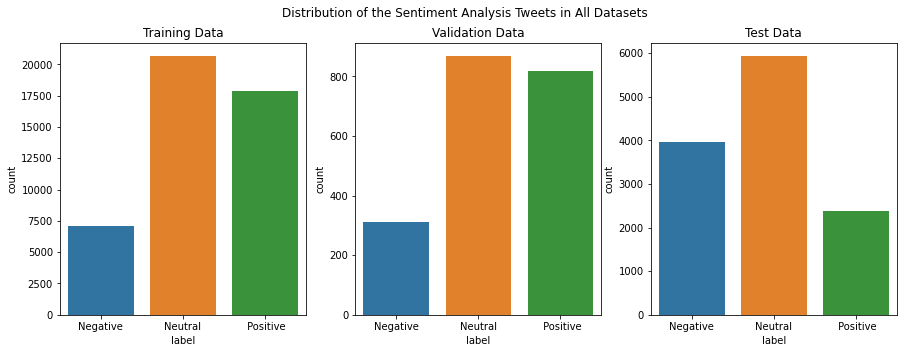

In [24]:
# Count Plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle('Distribution of the Sentiment Analysis Tweets in All Datasets')

sns.countplot(ax=axes[0], x=sentiment_train_labels.label)
axes[0].set_title('Training Data')
axes[0].set_xticklabels(labels)

sns.countplot(ax=axes[1], x=sentiment_val_labels.label)
axes[1].set_title('Validation Data')
axes[1].set_xticklabels(labels)

sns.countplot(ax=axes[2], x=sentiment_test_labels.label)
axes[2].set_title('Test Data')
axes[2].set_xticklabels(labels)

# Preprocessing

## Checking for null values

In [25]:
print("Number of NULL values in the hate training set: ", hate_train_df['tweet'].isnull().values.sum())
print("Number of NULL values in the hate validation set: ", hate_val_df['tweet'].isnull().values.sum())
print("Number of NULL values in the hate testing set: ", hate_test_df['tweet'].isnull().values.sum(), '\n')

print("Number of NULL values in the emotion recognition training set: ", emotion_train_df['tweet'].isnull().values.sum())
print("Number of NULL values in the emotion recognition validation set: ", emotion_val_df['tweet'].isnull().values.sum())
print("Number of NULL values in the emotion recognition test set: ", emotion_test_df['tweet'].isnull().values.sum(), '\n')

print("Number of NULL values in the emotion sentiment analysis training set: ", sentiment_train_df['tweet'].isnull().values.sum())
print("Number of NULL values in the emotion sentiment analysis validation set: ", sentiment_val_df['tweet'].isnull().values.sum())
print("Number of NULL values in the emotion sentiment analysis test set: ", sentiment_test_df['tweet'].isnull().values.sum())


Number of NULL values in the hate training set:  7
Number of NULL values in the hate validation set:  1
Number of NULL values in the hate testing set:  0 

Number of NULL values in the emotion recognition training set:  0
Number of NULL values in the emotion recognition validation set:  0
Number of NULL values in the emotion recognition test set:  0 

Number of NULL values in the emotion sentiment analysis training set:  0
Number of NULL values in the emotion sentiment analysis validation set:  0
Number of NULL values in the emotion sentiment analysis test set:  0


### Droping null values from the hate speech training set

In [26]:
print(hate_train_df.shape)
print(hate_train_labels.shape)
hate_train_df

(9000, 1)
(9000, 1)


,tweet
0,@user nice new signage. Are you not concerned ...
1,A woman who you fucked multiple times saying y...
2,@user @user real talk do you have eyes or were...
3,your girlfriend lookin at me like a groupie in...
4,Hysterical woman like @user
...,...
8995,Oooohhhh bitch didn't even listen to the dead ...
8996,@user Good Luck @user More Americans #WalkAway...
8997,Bitch you can't keep up so stop trying
8998,@user @user @user @user @user @user Japan is a...


In [27]:
hate_train_labels

,label
0,0
1,1
2,1
3,1
4,0
...,...
8995,0
8996,0
8997,1
8998,0


In [28]:
df = pd.concat([hate_train_df, hate_train_labels], axis=1)
df

,tweet,label
0,@user nice new signage. Are you not concerned ...,0
1,A woman who you fucked multiple times saying y...,1
2,@user @user real talk do you have eyes or were...,1
3,your girlfriend lookin at me like a groupie in...,1
4,Hysterical woman like @user,0
...,...,...
8995,Oooohhhh bitch didn't even listen to the dead ...,0
8996,@user Good Luck @user More Americans #WalkAway...,0
8997,Bitch you can't keep up so stop trying,1
8998,@user @user @user @user @user @user Japan is a...,0


In [29]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [30]:
hate_train_df = df[['tweet']]
hate_train_labels = df[['label']]
hate_train_df

,tweet
0,@user nice new signage. Are you not concerned ...
1,A woman who you fucked multiple times saying y...
2,@user @user real talk do you have eyes or were...
3,your girlfriend lookin at me like a groupie in...
4,Hysterical woman like @user
...,...
8988,Oooohhhh bitch didn't even listen to the dead ...
8989,@user Good Luck @user More Americans #WalkAway...
8990,Bitch you can't keep up so stop trying
8991,@user @user @user @user @user @user Japan is a...


In [31]:
hate_train_labels

,label
0,0
1,1
2,1
3,1
4,0
...,...
8988,0
8989,0
8990,1
8991,0


In [32]:
print("Number of NULL values in the hate training set: ", hate_train_df['tweet'].isnull().values.sum())
print(hate_train_df.shape)
print(hate_train_labels.shape)

Number of NULL values in the hate training set:  0
(8993, 1)
(8993, 1)


### Dropping null values from the hate speech validation set

In [33]:
print("Number of NULL values in the hate validation set: ", hate_val_df['tweet'].isnull().values.sum())

Number of NULL values in the hate validation set:  1


In [34]:
hate_val_df

,tweet
0,"@user @user If book Claire wanted to ""stay in ..."
1,After arriving in the EU refugees make protest...
2,😳👇
3,@user Worst thing is if they are that stupid t...
4,@user Say's the HYSTERICAL woman. It is woman ...
...,...
995,Pass #MeritBased Immigration. Kill #ChainMigra...
996,imagine chaeyoung cutting some cooked meat for...
997,I usually dont hate people but I actually hate...
998,Cameron stopped immigrants voting on the EU in...


In [35]:
hate_val_labels

,label
0,0
1,0
2,0
3,1
4,0
...,...
995,1
996,0
997,1
998,1


In [36]:
df = pd.concat([hate_val_df, hate_val_labels], axis=1)
df

,tweet,label
0,"@user @user If book Claire wanted to ""stay in ...",0
1,After arriving in the EU refugees make protest...,0
2,😳👇,0
3,@user Worst thing is if they are that stupid t...,1
4,@user Say's the HYSTERICAL woman. It is woman ...,0
...,...,...
995,Pass #MeritBased Immigration. Kill #ChainMigra...,1
996,imagine chaeyoung cutting some cooked meat for...,0
997,I usually dont hate people but I actually hate...,1
998,Cameron stopped immigrants voting on the EU in...,1


In [37]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(999, 2)

In [38]:
hate_val_df = df[['tweet']]
hate_val_labels = df[['label']]
print(hate_val_df.shape)
print(hate_val_labels.shape)

(999, 1)
(999, 1)


In [39]:
print("Number of NULL values in the hate training set: ", hate_train_df['tweet'].isnull().values.sum())
print("Number of NULL values in the hate validation set: ", hate_val_df['tweet'].isnull().values.sum())
print("Number of NULL values in the hate testing set: ", hate_test_df['tweet'].isnull().values.sum(), '\n')

Number of NULL values in the hate training set:  0
Number of NULL values in the hate validation set:  0
Number of NULL values in the hate testing set:  0 



## Cleaning Tweets Text

Removing the **#** **hashtag** symbols, **RT** acronym, and @user mentions

In [40]:
# Create a function to clean the tweets
def cleanTxt(text):
  text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
  text = re.sub('#', '', text) # Removing '#' hash tag
  text = re.sub('RT[\s]+', '', text) # Removing RT
  # text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
 
  return text

Apply cleaning on all datasets

In [41]:
# Clean the tweets
sentiment_train_df['tweet'] = sentiment_train_df['tweet'].apply(cleanTxt)
sentiment_val_df['tweet'] = sentiment_val_df['tweet'].apply(cleanTxt)
sentiment_test_df['tweet'] = sentiment_test_df['tweet'].apply(cleanTxt)

emotion_train_df['tweet'] = emotion_train_df['tweet'].apply(cleanTxt)
emotion_val_df['tweet'] = emotion_val_df['tweet'].apply(cleanTxt)
emotion_test_df['tweet'] = emotion_test_df['tweet'].apply(cleanTxt)

hate_train_df['tweet'] = hate_train_df['tweet'].apply(cleanTxt)
hate_val_df['tweet'] = hate_val_df['tweet'].apply(cleanTxt)
hate_test_df['tweet'] = hate_test_df['tweet'].apply(cleanTxt)

# Show the cleaned tweets
sentiment_train_df

,tweet
0,"""QT In the original draft of the 7th book, Re..."
1,"""Ben Smith / Smith (concussion) remains out of..."
2,Sorry bout the stream last night I crashed out...
3,Chase Headley's RBI double in the 8th inning o...
4,Alciato: Bee will invest 150 million in Janua...
...,...
45610,"\""""So amazing to have the beautiful Lady Gaga..."
45611,"9 September has arrived, which means Apple's n..."
45612,Leeds 1-1 Sheff Wed. Giuseppe Bellusci securin...
45613,no I'm in hilton head till the 8th lol go to ...


## Tokenizing

Exploring the tokenization process

In [42]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [43]:
sentiment_train_df.iloc[3256,0]

'Would take Pato all day long as a 3rd striker behind Berahino and Kane for a bench or cup player. '

In [44]:
# tokenizing and removing white spaces while keepng punctuation
sentence_sample = sentiment_train_df.iloc[3256,0]
token_sample = tokenizer.tokenize(sentence_sample)
print(token_sample)

['would', 'take', 'pat', '##o', 'all', 'day', 'long', 'as', 'a', '3rd', 'striker', 'behind', 'be', '##rah', '##ino', 'and', 'kane', 'for', 'a', 'bench', 'or', 'cup', 'player', '.']


The tokenizer is 'masking' or tokenizing emojis as [UNK]


In [45]:
print(emotion_train_df.iloc[654,0])

  Did they get the wrong fur Pal? shocking 😱 


In [46]:
# The tokenizer is 'masking' or tokenizing emojis as [UNK]
tweet_sample = emotion_train_df.iloc[654,0]
token_sample = tokenizer.tokenize(tweet_sample)
print(token_sample)

['did', 'they', 'get', 'the', 'wrong', 'fur', 'pal', '?', 'shocking', '[UNK]']


Converting the corpus into IDs of unqiue integers associated with each token. 

Convert each token to its ID, and that is an integer representing the index of that token in the vocabulary of the model,


In [47]:
token_id_sample = tokenizer.convert_tokens_to_ids(token_sample)
print(token_id_sample)

[2106, 2027, 2131, 1996, 3308, 6519, 14412, 1029, 16880, 100]


We have to provide sequences of equal length therefore we'll add some padding.

Then pass "attention mask" where each term has a value of 1 and each padding character has a value of 0

Special tokens are needed for separating betwen sentences and that's an artifact from the way that BERT initially trained.  telling BERT that we're interested in squence classification. "

Exploring types of tokens when encoding them into IDs

In [48]:
print("Types of tokens and their IDs:", tokenizer.special_tokens_map)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id) # CLS is sequence/text classification task
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.mask_token, tokenizer.mask_token_id)

Types of tokens and their IDs: {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}
[PAD] 0
[UNK] 100
[CLS] 101
[SEP] 102
[MASK] 103


Exploring the encoding process

In [49]:
encoding = tokenizer.encode_plus( # why plus?
        
    text = tweet_sample,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    # pad_to_max_length=True,
    truncation=True,
    max_length=60, # number of tokens
    padding='max_length',
    return_attention_mask = True,
    return_tensors='pt',  # Return PyTorch tensors, and tf can be used for TensorFlow as well
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [50]:
encoded_seq = encoding['input_ids'][0]
print("Encoded sequence (IDs):\n", encoded_seq)
print("Attention Mask:\n", encoding['attention_mask'])

Encoded sequence (IDs):
 tensor([  101,  2106,  2027,  2131,  1996,  3308,  6519, 14412,  1029, 16880,
          100,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Attention Mask:
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [51]:
print("Converting the encoded sequence back to tokens:\n", tokenizer.convert_ids_to_tokens(encoded_seq))

Converting the encoded sequence back to tokens:
 ['[CLS]', 'did', 'they', 'get', 'the', 'wrong', 'fur', 'pal', '?', 'shocking', '[UNK]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


Choosing the right size of sequence (or number of tokens) for our dataset is necessary because the larger the sequence length the slower is the process of training the model because there is a corelation between the two.

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


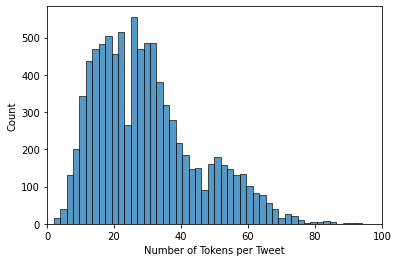

In [52]:
token_lens = []

for each_tweet in hate_train_df.tweet:
  
  tokens = tokenizer.encode(each_tweet, max_length=512) # max length by the model
  token_lens.append(len(tokens)) 


sns.histplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Number of Tokens per Tweet'); 

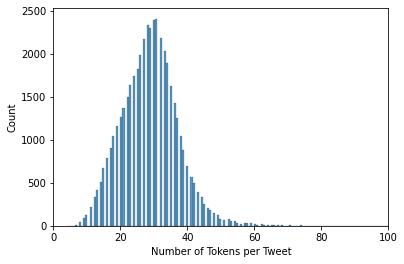

In [53]:
token_lens = []

for each_tweet in sentiment_train_df.tweet:
  
  tokens = tokenizer.encode(each_tweet, max_length=512) # max length by the model
  token_lens.append(len(tokens)) 


sns.histplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Number of Tokens per Tweet'); 

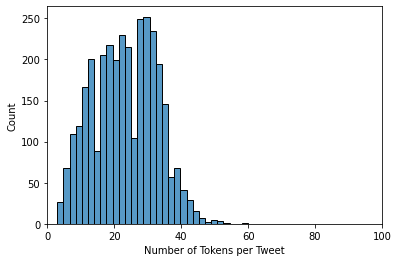

In [54]:
token_lens = []

for each_tweet in emotion_train_df.tweet:
  
  tokens = tokenizer.encode(each_tweet, max_length=512) # max length by the model
  token_lens.append(len(tokens)) 


sns.histplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Number of Tokens per Tweet'); 

# BERT: Exploring Initial Model

Loading the dataset to BERT using PyTorch library

In [55]:
MAX_LEN = 100  # The highest number of tokens in our dataset
BATCH_SIZE = 16

class SentimentsDataset(Dataset):

  def __init__(self, sentiment, targets, tokenizer, max_len):

    self.sentiment = sentiment
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):

    return len(self.sentiment)

  def __getitem__(self, item):

    sentiment = str(self.sentiment[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(

      sentiment,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',

    )

    return {

      'sentiment_text': sentiment,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [56]:
def create_data_loader(df, labels, tokenizer, max_len, batch_size):

  ds = SentimentsDataset(
           
      sentiment=df.tweet.to_numpy(),
      targets=labels.label.to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len

  )

  return DataLoader(
      
      ds,
      batch_size=batch_size,
      num_workers=4

  )

train_data_loader = create_data_loader(sentiment_train_df, sentiment_train_labels, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(sentiment_val_df, sentiment_val_labels, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(sentiment_test_df, sentiment_test_labels, tokenizer, MAX_LEN, BATCH_SIZE)

In [57]:
data = next(iter(train_data_loader))

data.keys()

(['sentiment_text', 'input_ids', 'attention_mask', 'targets'])

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])
